In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
from keras.callbacks import History, TensorBoard

Using TensorFlow backend.


In [2]:
def get_img(path):
    img = cv2.imread(path)
    resized_img = cv2.resize(img, (128, 128))
    return resized_img

In [3]:
def load_train_data(path):
    x_train = []
    
    for sample in os.listdir(path):
        comp_file_path = path + '/' + sample
        x = get_img(comp_file_path)
        x_train.append(x)
    return x_train

In [4]:
def load_test_data(path):
    x_test = []
    
    for sample in os.listdir(path):
        comp_file_path = path+'/'+sample
        x = get_img(comp_file_path)
        x_test.append(x)
        
    return x_test

In [5]:
#training data
training_data_path = '/mnt/disks/slow1/video_processing/exp/AE_arch/data/movie_data/bbs_data_split/train_500/frames'
train_data = load_train_data(training_data_path)
x_train_data = np.array(train_data)
print(x_train_data.shape)

#testing data
testing_data_path = '/mnt/disks/slow1/video_processing/exp/AE_arch/data/movie_data/bbs_data_split/test_200/frames'
test_data = load_test_data(testing_data_path)
x_test_data = np.array(test_data)
print(x_test_data.shape)

(500, 128, 128, 3)
(200, 128, 128, 3)


In [6]:
#dataset
img_size = x_train_data.shape[1]
x_train = np.reshape(x_train_data, [-1, img_size, img_size, 3])
x_test = np.reshape(x_test_data, [-1, img_size, img_size, 3])
x_train = x_train_data.astype('float32') / 255
x_test = x_test_data.astype('float32') / 255
print(x_train.shape, x_test.shape)

noise_factor = 0.2
x_train_noisy = x_train + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_tran_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

(500, 128, 128, 3) (200, 128, 128, 3)


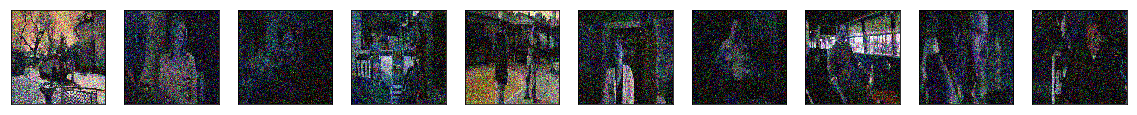

In [7]:
#display noisy images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(128, 128, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
input_shape = (img_size, img_size, 3)
batch_size = 4
kernel_size = 3
filters = 32
latent_dim = 2
epochs = 500
print(input_shape)

(128, 128, 3)


In [9]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train_noisy.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
__________

In [9]:
input_img = Input(shape=input_shape, name='encoder_input')

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img, encoded)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
__________

In [9]:
input_img = Input(shape=input_shape, name='encoder_input')

#encoder 5 layers with more no of feature maps
x = Conv2D(8, (5,5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (5,5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(input_img, encoded)
#encoder.summary()

#decoder 5 layers with more no of feature maps
x = Conv2D(128, (5, 5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [10]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
                #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 500 samples, validate on 200 samples
Epoch 1/500
500/500 [==============================] - 6s 12ms/step - loss: 0.1199 - acc: 0.0925 - val_loss: 0.0944 - val_acc: 0.1100
Epoch 2/500
500/500 [==============================] - 1s 2ms/step - loss: 0.0686 - acc: 0.1482 - val_loss: 0.0675 - val_acc: 0.3194
Epoch 3/500
500/500 [==============================] - 1s 2ms/step - loss: 0.0578 - acc: 0.3239 - val_loss: 0.0576 - val_acc: 0.3238
Epoch 4/500
500/500 [==============================] - 1s 2ms/step - loss: 0.0405 - acc: 0.3251 - val_loss: 0.0744 - val_acc: 0.3203
Epoch 5/500
500/500 [==============================] - 1s 2ms/step - loss: 0.0219 - acc: 0.2232 - val_loss: 0.0454 - val_acc: 0.1320
Epoch 6/500
500/500 [==============================] - 1s 2ms/step - loss: 0.0198 - acc: 0.2824 - val_loss: 0.0638 - val_acc: 0.5386
Epoch 7/500
500/500 [==============================] - 1s 2ms/step - loss: 0.0191 - acc: 0.5583 - val_loss: 0.0487 - val_acc: 0.5484
Epoch 8/500
500/500 [=

Text(0.5,1,'validation loss')

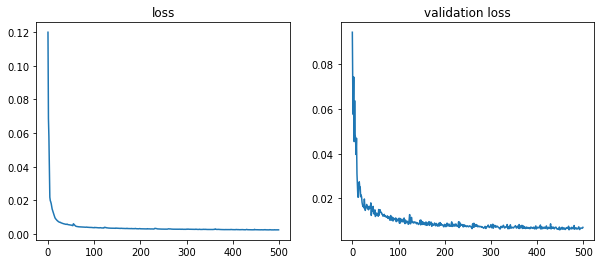

In [11]:
#print training history
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(autoencoder.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(autoencoder.history.history['val_loss'])
ax2.set_title('validation loss')

(200, 32, 32, 128)


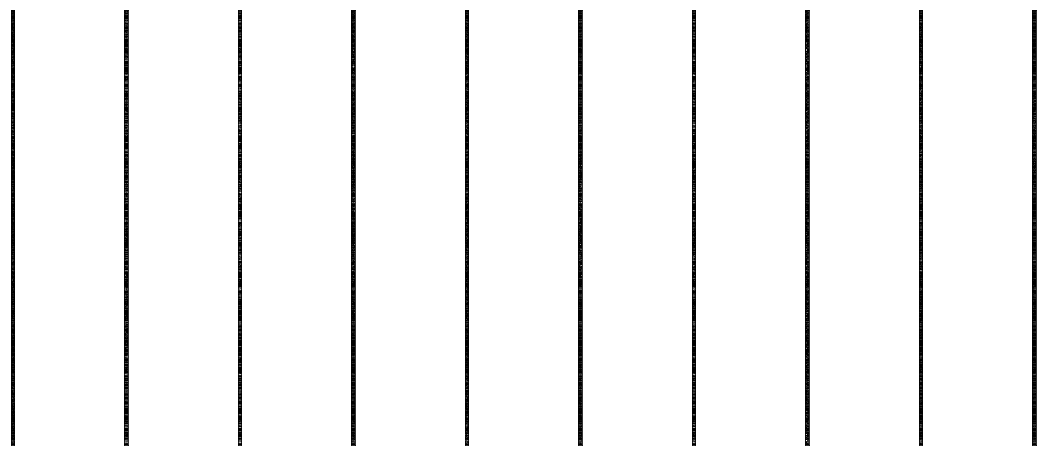

In [12]:
encoded_imgs = encoder.predict(x_test_noisy)
print(encoded_imgs.shape)
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(32, 32*128).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
decoded_imgs = autoencoder.predict(x_test_noisy)

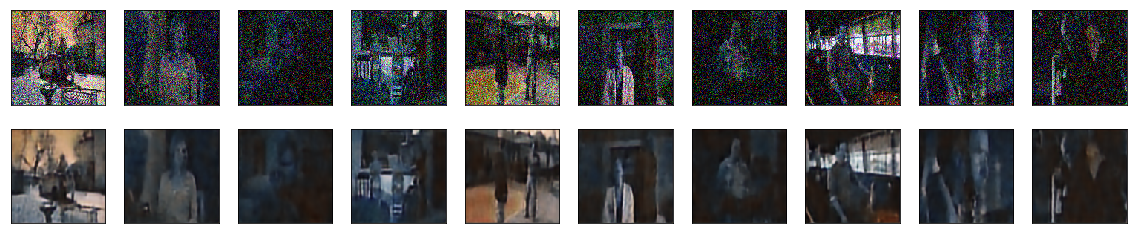

In [14]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(128,128,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(128, 128, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()